In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"


from typing import Any, Callable, List, Tuple, Dict

from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST, MNIST



from lightning.pytorch.utilities.types import STEP_OUTPUT, OptimizerLRScheduler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils

import lightning.pytorch as L
from einops import rearrange, reduce, repeat

torch.manual_seed(2023)
np.random.seed(2023)
torch.set_float32_matmul_precision('medium')


In [2]:
# trainset = FashionMNIST(root='~/.cache/torchvision_cache', train=True, download=True,
#                         transform=transforms.Compose([
#                         transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]))


trainset = MNIST(root="~/.cache/torchvision_cache",
                      download=True, train=True, transform=transforms.ToTensor())


torch.Size([1, 28, 28])


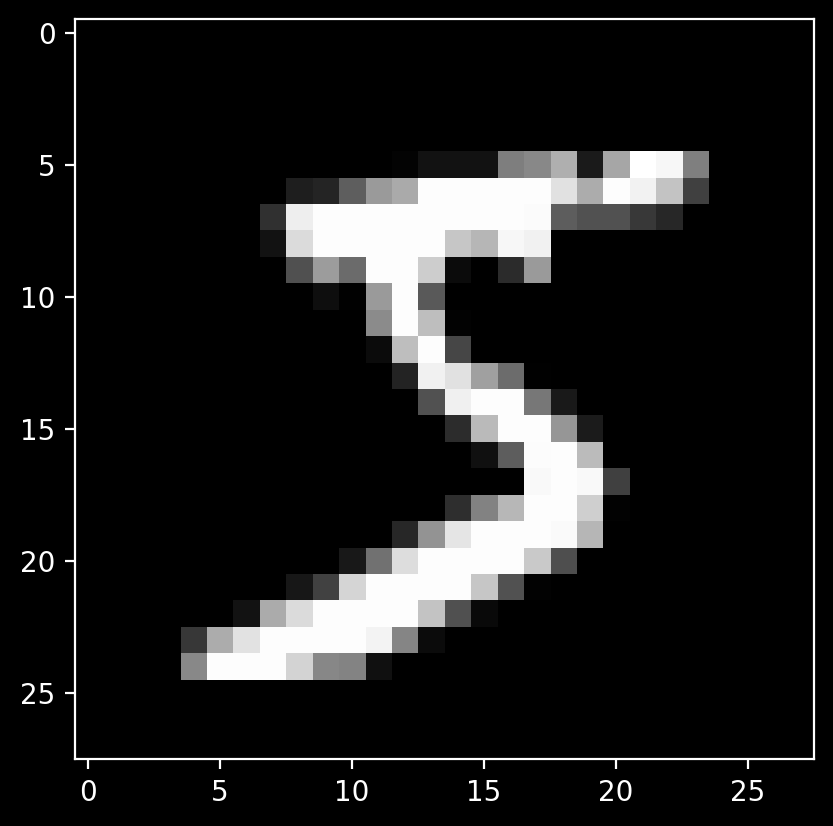

In [3]:
plt.imshow(trainset[0][0].squeeze(), cmap='gray')
print(trainset[0][0].size())


In [4]:
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)


In [5]:
class VAELoss(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
    def forward(self, x: torch.Tensor, x_hat: torch.Tensor, mean: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        reproduction_loss = F.binary_cross_entropy(input=x_hat, target=x, reduction="sum")
        kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        
        return reproduction_loss + kl_divergence


In [6]:
from typing import Any

from lightning.pytorch.utilities.types import STEP_OUTPUT, OptimizerLRScheduler


class VAE(L.LightningModule):
    def __init__(self) -> None:
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            
        )
        
        # latent space
        self.latent_mean = nn.Linear(512, 256)
        self.latent_log_var = nn.Linear(512, 256)
        
        
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.LeakyReLU(0.2),
            nn.Sigmoid()
        )
        
    
    def reparameterisation(self, mean: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        # assuming log_var
        # un-log and then sqrt to get the std-dev 
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std).to(self.device)
        return mean + eps * std
        
        
    def forward(self, x: torch.Tensor) -> Any:
        out = self.encoder(x)
        
        mean = self.latent_mean(out)
        mean = F.leaky_relu(mean, 0.2)
        
        log_var = self.latent_log_var(out)
        log_var = F.leaky_relu(log_var, 0.2)
        
        z = self.reparameterisation(mean, log_var)
        
        x_hat = self.decoder(z)
        
        
        return x_hat, mean, log_var
    
    
    def configure_optimizers(self) -> OptimizerLRScheduler:
        return optim.AdamW(self.parameters(), lr=1e-3)
    
    
    def training_step(self, batch, batch_idx) -> STEP_OUTPUT:
        x, _ = batch
                
        x = torch.flatten(x, start_dim=1)
        
        x_hat, mean, log_var = self(x)
        
        loss = F.binary_cross_entropy(x_hat, x, reduction="sum")
        kl = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        loss += kl
        
        self.log('train_loss', loss, prog_bar=True)
        
        return {
            "loss": loss,
            "log": {
                "Loss/Training": loss
            }
        }


# model = VAE()
# x = torch.randn(8, 784)
# y = torch.zeros(8, )

# x_hat, mean, log_var = model(x)
# print(x_hat)

# loss = F.binary_cross_entropy(x_hat, x, reduction="sum")
# kl = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
# print(loss + kl)


In [7]:
def train() -> Any:
    logger = L.loggers.TensorBoardLogger("tb_logs", name="vae_fashion_mnist", log_graph=True)
    
    
    model = VAE()
    trainer = L.Trainer(max_epochs=5, devices=1, accelerator="gpu", logger=logger)
    # trainer = L.Trainer(max_epochs=5, devices=1, accelerator="cpu", logger=logger)
    trainer.fit(model, trainloader)
    
    return model


model = train()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | encoder        | Sequential | 664 K 
1 | latent_mean    | Linear     | 131 K 
2 | latent_log_var | Linear     | 131 K 
3 | decoder        | Sequential | 796 K 
----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.895     Total estimated model params size (MB)
/home/shawon/miniconda3/envs/exp/lib/python3.10/site-packages/lightning/pytorch/loggers/tensorboard.py:187: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.
/home/shawon/miniconda3/envs/exp/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [8]:
# %load_ext tensorboard
# %tensorboard --logdir tb_logs/


torch.Size([28, 28])


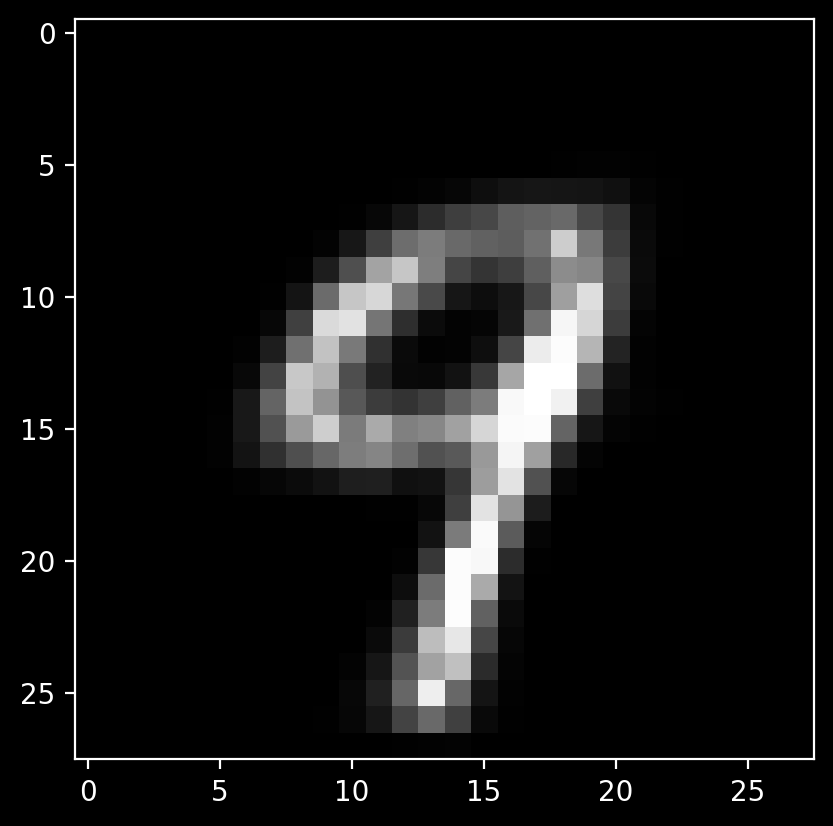

In [23]:
with torch.no_grad():
    x = torch.randn(256, ).to(model.device)
    out = model.decoder(x)
    
    
    
    out = torch.unflatten(out, -1, (28, 28))
    print(out.size())
    
    plt.imshow(out, cmap='gray')


5


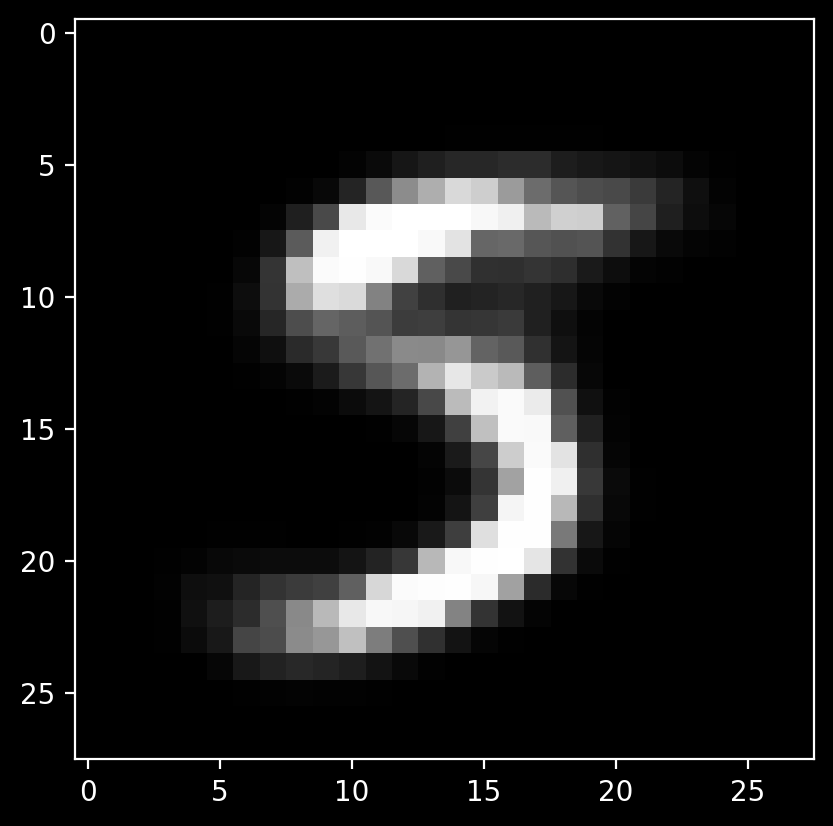

In [20]:
with torch.no_grad():
    image = torch.flatten(trainset[0][0])
    print(trainset[0][1])
    out, _ , _ = model(image)
    
    out = torch.unflatten(out, -1, (28, 28))
    
plt.imshow(torch.exp(out.cpu()), cmap="gray")
